In [96]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta, TH
import matplotlib.pyplot as plt

In [106]:
def expiryDates():

    today = datetime.today()
    
    cmon = today.month
    if_month_next=(today + relativedelta(weekday=TH(1))).month
    next_thursday_expiry=today + relativedelta(weekday=TH(1))
   
    if (if_month_next!=cmon):
        month_last_thu_expiry= today + relativedelta(weekday=TH(5))
        if (month_last_thu_expiry.month!=if_month_next):
            month_last_thu_expiry= today + relativedelta(weekday=TH(4))
    else:
        for i in range(1, 7):
            t = today + relativedelta(weekday=TH(i))
            if t.month != cmon:
                # since t is exceeded we need last one  which we can get by subtracting -2 since it is already a Thursday.
                t = t + relativedelta(weekday=TH(-2))
                month_last_thu_expiry=t
                break
    str_month_last_thu_expiry=str(int(month_last_thu_expiry.strftime("%d")))+month_last_thu_expiry.strftime("%b").upper()+month_last_thu_expiry.strftime("%Y")
    str_next_thursday_expiry=str(int(next_thursday_expiry.strftime("%d")))+next_thursday_expiry.strftime("%b").upper()+next_thursday_expiry.strftime("%Y")
    return (str_next_thursday_expiry,str_month_last_thu_expiry)

In [109]:
weekly_expiry,monthly_expiry = expiryDates()

print("Next(Weekly) Expiry = " + weekly_expiry)
print("Monthly Expiry = " + monthly_expiry)

Next(Weekly) Expiry = 10SEP2020
Monthly Expiry = 24SEP2020


In [151]:
def topKOptionCalls(instrument,symbol,expirydate,k):

    urlheader = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36",
      "authority": "www.nseindia.com",
      "scheme":"https"
    }
    
    url="https://www1.nseindia.com/live_market/dynaContent/live_watch/option_chain/optionKeys.jsp?"
    params_index="segmentLink=17&instrument="+instrument+"&symbol="+symbol+"&date="
    params_stock=""
    
    url_encoded = url+params_index+expirydate
    req = requests.get(url_encoded, headers=urlheader)
    soup = BeautifulSoup(req.content, "lxml")
    table = soup.find('table', id="octable")
    
    rows = table.findAll('tr')
    header_text = []
    headers = rows[1]
    remove_indices_for_put = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,18,22]
    remove_indices_for_call = [0,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22]
     
    for th in headers.findAll('th'):
        header_text.append(th.text)
    
    header_text = [i for j, i in enumerate(header_text) if j not in remove_indices_for_put]
    df_call = pd.DataFrame(columns=header_text)
    df_put = pd.DataFrame(columns=header_text)
    
    for row in rows[2:-1]:
        row_text = []
        row_text_call = []
        row_text_put = []
        for row_element in row.findAll(['th', 'td']):
            row_text.append(row_element.text.replace('\n', '').strip())
    
        row_text_put = [i for j, i in enumerate(row_text) if j not in remove_indices_for_put]
        for i in range(len(row_text_put)):
            if (row_text_put[i]=='-'):
                row_text_put[i]=0
            else:
                row_text_put[i]=row_text_put[i].replace(',', '')
                row_text_put[i]=float(row_text_put[i])
        row_text_call = [i for j, i in enumerate(row_text) if j not in remove_indices_for_call]
        row_call_temp=[None] * len(row_text_call)
        for i in range(len(row_text_call)):       
            if (row_text_call[i]=='-'):
                row_call_temp[len(row_text_call)-i-1]=0
            else:
                row_text_call[i]=row_text_call[i].replace(',', '')
                row_text_call[i]=float(row_text_call[i])
                row_call_temp[len(row_text_call)-i-1]=row_text_call[i]
        df_call = df_call.append(pd.Series(dict(zip(df_call.columns, row_call_temp))), ignore_index=True)
        df_put = df_put.append(pd.Series(dict(zip(df_put.columns, row_text_put))), ignore_index=True)    
        
        
    df_call['OI'] = pd.to_numeric(df_call['OI'])
    df_call=df_call.nlargest(k, ['OI'])
    df_call.set_index('Strike Price', inplace=True)
    print("Top "+ str(k) +" Strike price of Call Option for "+ symbol +" based on Open Interest for Expiry Date = "+expirydate)
    df_call=df_call.sort_index(axis = 0) 
    print(df_call)
    
   
    df_call.plot.barh(title='Top '+ str(k)   +' Call Option for ' + symbol + ' based on OI for Option Expiry = '+expirydate)
    
    print("================================================================================") 
    df_put['OI'] = pd.to_numeric(df_put['OI'])
    df_put=df_put.nlargest(k, ['OI'])
    df_put.set_index('Strike Price', inplace=True)
    print("Top "+ str(k) +" Strike price of Put Option for " + symbol +" based on Open Interest for Expiry Date = "+expirydate)
    print(df_put)
    df_put=df_put.sort_index(axis = 0) 
    df_put.plot.barh( title='Top '+ str(k)  + ' Put Option for ' + symbol + ' based on OI for Option Expiry = '+expirydate)
    return(df_call,df_put)

## Top 3 option writing Calls for BANKNIFTY for next weekly expiry

Top 3 Strike price of Call Option for BANKNIFTY based on Open Interest for Expiry Date = 10SEP2020
                LTP    Volume  Chng in OI        OI
Strike Price                                       
24000.0       103.3  563432.0    264900.0  764175.0
24500.0        45.0  273461.0    211975.0  568050.0
25000.0        22.2  208920.0    272200.0  676925.0
Top 3 Strike price of Put Option for BANKNIFTY based on Open Interest for Expiry Date = 10SEP2020
                 LTP    Volume  Chng in OI        OI
Strike Price                                        
21000.0        21.00  198186.0    352850.0  607875.0
23000.0       360.00  560829.0    116550.0  448675.0
22000.0        87.25  372597.0    187850.0  392475.0


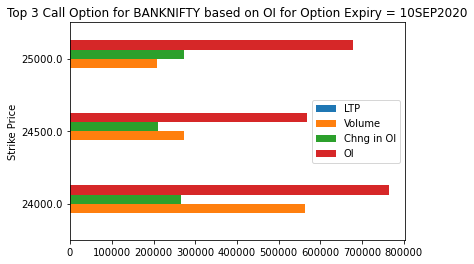

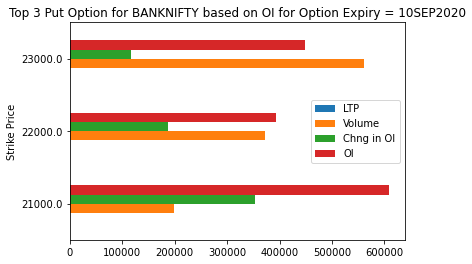

In [152]:
df_call_near_expiry,df_put_near_expiry = topKOptionCalls('OPTIDX','BANKNIFTY',weekly_expiry,3)

## Top 3 option writing Calls for NIFTY for next monthly expiry

Top 3 Strike price of Call Option for NIFTY based on Open Interest for Expiry Date = 10SEP2020
                LTP    Volume  Chng in OI         OI
Strike Price                                        
11500.0       52.85  563657.0   1411575.0  2407050.0
12000.0        4.25  167787.0   1378425.0  2662800.0
12500.0        2.50   92033.0   1162875.0  3082950.0
Top 3 Strike price of Put Option for NIFTY based on Open Interest for Expiry Date = 10SEP2020
                LTP    Volume  Chng in OI         OI
Strike Price                                        
11000.0       24.45  268396.0    888075.0  2000175.0
10500.0        4.75   69907.0    617625.0  1483875.0
10800.0       12.25   99947.0    666975.0  1431225.0


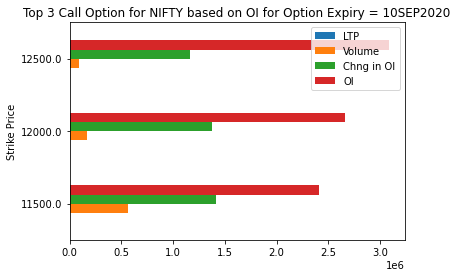

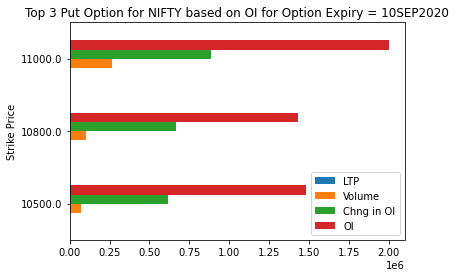

In [153]:
df_call_near_expiry,df_put_near_expiry = topKOptionCalls('OPTIDX','NIFTY',weekly_expiry,3)

## Top 3 option writing Calls for HDFCBANK for next monthly expiry

Top 3 Strike price of Call Option for HDFCBANK based on Open Interest for Expiry Date = 24SEP2020
                LTP  Volume  Chng in OI         OI
Strike Price                                      
1140.0        23.20  3187.0     47850.0   737000.0
1160.0        16.60  3017.0     -8250.0   902000.0
1200.0         7.95  2795.0     66550.0  1159950.0
Top 3 Strike price of Put Option for HDFCBANK based on Open Interest for Expiry Date = 24SEP2020
               LTP  Volume  Chng in OI        OI
Strike Price                                    
1120.0        36.0  1661.0    -13750.0  641300.0
1000.0         4.8  1287.0     15950.0  628650.0
1100.0        26.5  3246.0    -58300.0  549450.0


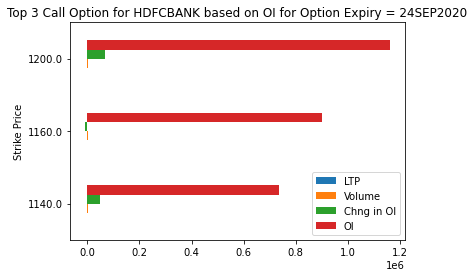

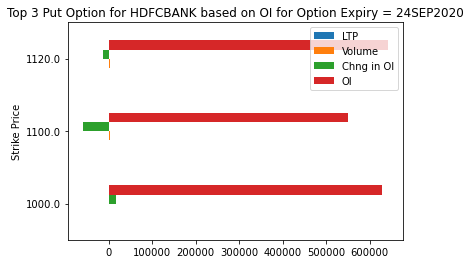

In [155]:
df_call_near_expiry,df_put_near_expiry = topKOptionCalls('OPTSTK','HDFCBANK',monthly_expiry,3)